# Classification Metrics and Class Imbalance
## (Featuring Some Logistic Regression Practice)

Let's start off with a page from [Google's Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative) and talk about a classic classification problem:

### The Boy Who Cried 'Wolf'

![adorable wolf image from instagram user fablefire: https://www.instagram.com/p/CCGgVLGFneE/](images/awoo.png)

In the old fable about the boy who cried 'wolf' there are two possible outcomes: 

- **No Wolf** - negative outcome, or 0
- **Wolf** - positive outcome, or 1

(I know, having a wolf arrive is not "positive" - but it is what we're trying to predict)

If you think of this as a model, where the shepherd is predicting whether or not a wolf will threaten the flock of sheep:

![outcome description for wolf scenarios as a confusion matrix](images/wolf_confusion_matrix.png)

So what does that look like with data?

In [1]:
# All of the imports

import pandas as pd
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix # New to version 0.22.2

In [2]:
df = pd.read_csv('data/titanic.csv', index_col = "PassengerId")

In [3]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Model-less Baseline

First of all, I want to see how well the model will do if it predicts the majority class. In other words, if the model only predicts that no one survives, what percentage of the time would it be right? 

How do we do this? Find the number of passengers who didn't survive, divide by the total number of passengers.

In [5]:
# Find percent who did not survive
df['Survived'].value_counts()[0] / len(df)

0.6161616161616161

In [6]:
# Another way to do this - the mean of this column gives the percentage of
# passengers who DID survive because it's a 0/1 binary - find the inverse
1 - df['Survived'].mean()

0.6161616161616161

To visualize:

In [7]:
num_passengers = len(df)

In [8]:
y_actual = df['Survived']

In [9]:
y_pred_baseline = [0] * num_passengers

In [10]:
accuracy_score(y_actual, y_pred_baseline)

0.6161616161616161

In [11]:
# A confusion matrix
confusion_matrix(y_actual, y_pred_baseline)

array([[549,   0],
       [342,   0]])

Or, prettier: 

<img alt="table view with colors to show results of modelless baseline" src="images/titanic_modelless_baseline_cm.png" height=200 width=200>

## Confusion Matrix &rarr; Classification Metrics

That block above, where we hashed out true negatives / true positives / false negatives / false positives, is called a **Confusion Matrix** - a summary of how well a classification model was able to predict each class. Across one axis you have the _predicted_ labels, and across the other axis you have the _actual_ labels, and thus you're able to clearly see the breakdown of where a model is making mistakes - and, more importantly, what kinds of mistakes your model is making.

So - how does a confusion matrix translate into classification metrics?

### Confusion Matrix Interpretation


<img alt="confusion matrix interpretation with metrics" src="images/confusion_matrix_interpretation.png" height=600 width=600>

Note that I've highlighted the most often used metrics in blue above. 

In other words, those metrics are:

- Accuracy: All True Predictions / All Predictions

- Precision score: TP / All Predicted Positives

- Recall or Sensitivity: TP / All Actual Positives 

There's one more score that's often referenced which balances precision and recall - it's called an [**F1 Score**](https://en.wikipedia.org/wiki/F1_score).

$$ \text{F1 Score} = 2 * \frac{ precision * recall}{precision + recall} $$


**Let's Discuss**: Why might we care more about precision than recall, or vice versa?

- 


----

Moving on - luckily SKLearn will of course calculate these scores for us. You can see all of their classification metrics [here](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

(Yes, there are more metrics - including the ROC-AUC score introduced in the curriculum - that we have not discussed so far. Stay tuned - we'll discuss that metric specifically in a future study group session!)

## Logistic Regression Practice

![monty python, 'nobody expects the logistic regression](images/nobodyexpectslogreg.jpg)

In general, I'll be following the imputation/scaling strategy outlined [here](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html) (just in a more laid-out way)

In [12]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


I want to use the columns: `Age`, `Fare`, `Sex`, and `Pclass` - a combination of types, also `Age` has null values.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [14]:
# First, let's encode our categorical column, Sex
enc_sex = pd.get_dummies(df['Sex'], drop_first=True)
enc_sex

# Add the column to the dataframe, but now encoded
df['is_Male'] = enc_sex

In [15]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_Male
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [16]:
# Defining my X and y
X = df[['Age', 'Pclass', 'Fare', 'is_Male']]
y = df['Survived']

In [17]:
# And then doing a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Age column has null values
714/891

0.8013468013468014

In [19]:
# For Age, I need to impute nulls
imputer = SimpleImputer(strategy='median')

X_train_nonulls = imputer.fit_transform(X_train)
X_test_nonulls = imputer.transform(X_test)

In [20]:
# Now, let's scale our data
scaler = StandardScaler()

X_train_processed = scaler.fit_transform(X_train_nonulls)
X_test_processed = scaler.transform(X_test_nonulls)

In [21]:
# Instantiate our model
logreg = LogisticRegression()

In [22]:
# Now, fitting our model and grabbing our training and testing predictions
logreg.fit(X_train_processed, y_train)

train_preds = logreg.predict(X_train_processed)
test_preds = logreg.predict(X_test_processed)

In [23]:
# Score?
logreg.score(X_test_processed, y_test)

0.7932960893854749

In [24]:
# Visualize
confusion_matrix(y_test, test_preds)

array([[89, 16],
       [21, 53]])

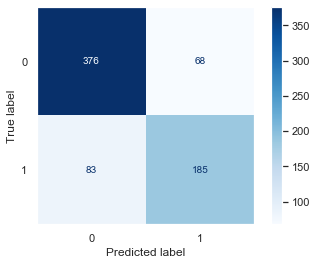

In [25]:
plot_confusion_matrix(logreg, X_train_processed, y_train,
                      cmap=plt.cm.Blues,     # Changing the color scheme
                      values_format=".3g")   # Formatting the numbers properly

plt.grid(False) # This just removes an annoying grid that shows up by default

plt.show()

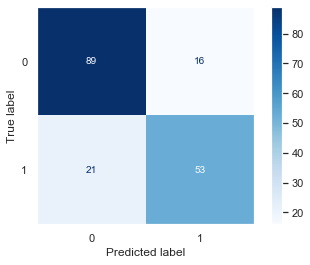

In [26]:
# Plotting the confusion matrix using SKLearn 
plot_confusion_matrix(logreg, X_test_processed, y_test,
                      cmap=plt.cm.Blues,     # Changing the color scheme
                      values_format=".3g")   # Formatting the numbers properly

plt.grid(False) # This just removes an annoying grid that shows up by default

plt.show()

In [27]:
# Printing the metrics nicely
metrics = {"Accuracy": accuracy_score,
           "Recall": recall_score,
           "Precision": precision_score,
           "F1-Score": f1_score}

for name, metric in metrics.items():
    print(f"{name}:"); print("="*len(name))
    print(f"TRAIN: {metric(y_train, train_preds):.4f}")
    print(f"TEST: {metric(y_test, test_preds):.4f}")
    print("*" * 15)

Accuracy:
TRAIN: 0.7879
TEST: 0.7933
***************
Recall:
TRAIN: 0.6903
TEST: 0.7162
***************
Precision:
TRAIN: 0.7312
TEST: 0.7681
***************
F1-Score:
TRAIN: 0.7102
TEST: 0.7413
***************


### Evaluation:

So, how'd we do? Specifically, how'd we do compared to our model-less baseline?

- Test set did a little better than train set (underfitting)
- Bettern precision than recall
- (F1 score always between precision and recall)

### Next Steps

What can we potentially do to improve this model?

- underfit => add more columns (feed more data)

## Class Imbalance

In [28]:
# What does a class imbalance look like?
y.value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Why do we care?

Think about it - you're asking a computer, which has NO idea what you're talking about or how to identify anything in any way other than how you tell it to identify things, to look at something completely new and categorize it. If you feed it 1000 emails, 950 of which are 'not spam' and 50 of which are 'spam,' and ask it to identify which are 'not spam,' it can just label everything as 'not spam' and be 95% correct! Not bad!

And yet... that doesn't do what you want at all. You want your model to learn the characteristics of 'spam' emails and actually identify the parts of it which are reliable predictors for 'spam' in general, something the computer is increasingly incentivized not to do as the majority in your datasets gets larger compared to the minority. If your target is really imbalanced, your model will have to work increasingly harder in order to do better than the model-less baseline of just predicting the majority class.

### What can we do about it?

#### Under-Sampling

Basically, take a sample to reduce the majority class to be the same size as the minority class.

Example:
```
minority = df.loc[df["category"] == "minority"]
majority = df.loc[df["category"] == "majority"].sample(n=len(minority))
```

Problems?

- Losing a lot of observations (in the 50 spam vs 950 not-spam example, we'd lose 900 rows!)


#### Over-Sampling

The opposite - keep resampling from our minority class until it's the same size as the majority class.

Example:
```
majority = df.loc[df["category"] == "majority"]
minority = df.loc[df["category"] == "minority"].sample(n=len(majority), replace=True)
```

Problems?

- Will over-fit to the minority class, since it'll see the same minority examples over and over again (in the same 50 spam vs 950 not-spam example, we'd likely repeat each of the rows in the minority class 19 times!)


#### Split The Difference

Basically, balance Under and Over sampling so that you do a bit of both - might be better than relying on just one of the above strategies.

#### Synthetic Data Creation - ADASYN and SMOTE

The **Synthetic Minority Oversampling Technique (SMOTE)** conducts cluster-based over-sampling. SMOTE works by finding all the instances of the minority category within the observations, drawing lines between those instances, and then creating new observations along those lines.

![SMOTE visualized](images/SMOTE_R_visualisation_3.png)

Image source is a great explainer on SMOTE (but uses R for the examples): https://rikunert.com/SMOTE_explained

This is better than simply using a random over-sample, yet not only are these synthetic samples not real data but also these samples are based on your existing minority. So, those new, synthetic samples can still result in over-fitting, since they're made from our original minority category. An additional pitfall you might run into is if one of your minority category is an outlier - you'll have new data that creates synthetic data based on the line between that outlier and another point in your minority, and maybe that new synthetic data point is also an outlier.

Another way to create synthetic data to over-sample our minority category is the **Adaptive Synthetic approach, ADASYN**. ADASYN works similarly to SMOTE, but it focuses on the points in the minority cluster which are the closest to the majority cluster, aka the ones that are most likely to be confused, and focuses on those. It tries to help out your model by focusing on where it might get confused, where 'spam' and 'not spam' are the closest, and making more data in your 'spam' minority category there.


Check out the library [imblearn](https://imbalanced-learn.org/stable/) for implementation of these!

And then, of course, sklearn has some methods to handle imbalanced datasets built right into some models - including logistic regression!

In [29]:
# Let's try a model with an adjusted hyperparameter...
logreg_b = LogisticRegression(class_weight='balanced')

In [30]:
# Now, fitting our model and grabbing our training and testing predictions
logreg_b.fit(X_train_processed, y_train)

train_preds_b = logreg_b.predict(X_train_processed)
test_preds_b = logreg_b.predict(X_test_processed)

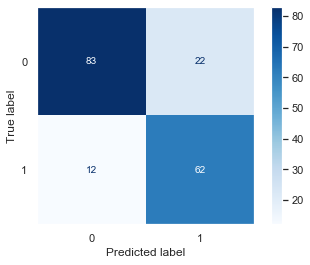

In [31]:
# Plotting the confusion matrix using SKLearn
plot_confusion_matrix(logreg_b, X_test_processed, y_test,
                      cmap=plt.cm.Blues,     # Changing the color scheme
                      values_format=".3g")   # Formatting the numbers properly

plt.grid(False) # This just removes an annoying grid that shows up by default

plt.show()

In [32]:
# Printing the metrics nicely
metrics = {"Accuracy": accuracy_score,
           "Recall": recall_score,
           "Precision": precision_score,
           "F1-Score": f1_score}

for name, metric in metrics.items():
    print(f"{name}:"); print("="*len(name))
    print(f"TRAIN: {metric(y_train, train_preds_b):.4f}")
    print(f"TEST: {metric(y_test, test_preds_b):.4f}")
    print("*" * 15)

Accuracy:
TRAIN: 0.7781
TEST: 0.8101
***************
Recall:
TRAIN: 0.7687
TEST: 0.8378
***************
Precision:
TRAIN: 0.6821
TEST: 0.7381
***************
F1-Score:
TRAIN: 0.7228
TEST: 0.7848
***************


## Neat Tricks (if we have time)

Let's try the code directly from [imputation/scaling strategy example I referenced earlier](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html), which uses some neat tricks:

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [34]:
numeric_features = ['Age', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['Sex', 'Pclass']
categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Survived'), y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.799


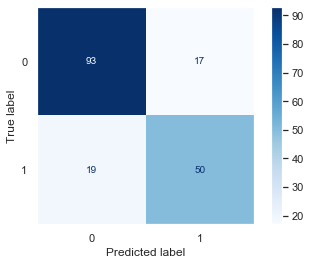

In [35]:
# Plotting the confusion matrix using SKLearn
plot_confusion_matrix(clf, X_test, y_test,
                      cmap=plt.cm.Blues,     # Changing the color scheme
                      values_format=".3g")   # Formatting the numbers properly

plt.grid(False) # This just removes an annoying grid that shows up by default

plt.show()

In [36]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [37]:
for name, metric in metrics.items():
    print(f"{name}:"); print("="*len(name))
    print(f"TRAIN: {metric(y_train, y_train_pred):.4f}")
    print(f"TEST: {metric(y_test, y_test_pred):.4f}")
    print("*" * 15)

Accuracy:
TRAIN: 0.7949
TEST: 0.7989
***************
Recall:
TRAIN: 0.6960
TEST: 0.7246
***************
Precision:
TRAIN: 0.7510
TEST: 0.7463
***************
F1-Score:
TRAIN: 0.7224
TEST: 0.7353
***************


## Resources:

- [SMOTE Explained for Noobs](https://rikunert.com/SMOTE_explained) (the R tutorial I linked earlier)
- [Resampling Strategies for Imbalanced Datasets](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)
- Machine Learning Mastery: [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
- [Handling Imbalanced Datasets in Deep Learning](https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758)